# Medical images final project
Mira Budenova

In [27]:
!pip install pydicom

In [1]:
import os
import pydicom
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio

In [2]:
reference_folder = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm'
tumor_path = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm_ManualROI_Tumor.dcm'
liver_path = 'C://Users//Amir//Downloads//RadCTTACEomics_1053-20250409T154823Z-001//RadCTTACEomics_1053//10_AP_Ax2.50mm_ManualROI_Liver.dcm'

In [3]:
def load_reference(folder):
    # Load all DICOM files
    dicoms = [pydicom.dcmread(os.path.join(folder, f)) for f in os.listdir(folder) if f.endswith('.dcm')]
    
    # Sort slices based on Image Position Patient (Z coordinate)
    dicoms.sort(key=lambda x: float(x.ImagePositionPatient[2]))

    # Check if all slices belong to the same acquisition
    acquisition_numbers = {d.AcquisitionNumber for d in dicoms if hasattr(d, 'AcquisitionNumber')}
    if len(acquisition_numbers) > 1:
        print(f"Multiple acquisitions found: {acquisition_numbers}")
    else:
        print("All slices are from a single acquisition.")

    # Stack into 3D numpy array
    image_volume = np.stack([d.pixel_array for d in dicoms])

    z_positions = [float(d.ImagePositionPatient[2]) for d in dicoms]
    return dicoms, image_volume, z_positions

In [4]:
ct_files, ct_volume, ct_z_positions = load_reference(reference_folder)

All slices are from a single acquisition.


In [5]:
def load_mask(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    mask = dcm.pixel_array
    frame_z_positions = [
    float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
    for frame in dcm.PerFrameFunctionalGroupsSequence
]
    return mask, frame_z_positions

In [6]:
tumor_mask, tumor_z_positions = load_mask(tumor_path)
liver_mask, liver_z_positions = load_mask(liver_path)

### TODO: Check it/comment differently 

In [12]:
def create_segmentation_masks(mask, z_positions):
    # Step 4: Handle potential minor Z misalignments using Z position matching
    mask_volume = np.zeros_like(ct_volume, dtype=bool)
    ct_z_array = np.array(ct_z_positions)

    # Reorder the tumor mask based on closest Z positions between CT and segmentation
    for f, seg_z in enumerate(z_positions):
        slice_idx = int(np.argmin(np.abs(ct_z_array - seg_z)))
        
        # Check if the slice index is within bounds
        if slice_idx < mask_volume.shape[0]:  # Ensure you don't go out of bounds
            mask_volume[slice_idx, :, :] = mask[f] > 0  # True where tumor

    return mask_volume



In [13]:
tumor_mask_volume = create_segmentation_masks(tumor_mask, tumor_z_positions)
liver_mask_volume = create_segmentation_masks(liver_mask, liver_z_positions)

### Don't touch this for now

In [ ]:
# Make an empty volume the same shape as ct_volume
mask_volume = np.zeros_like(ct_volume, dtype=bool)
# Convert z_positions to a NumPy array for better handling
ct_z_array = np.array(ct_z_positions)

for f, seg_z in enumerate(tumor_z_positions):
    # Find the CT slice whose Z is closest to this frame's Z
    slice_idx = int(np.argmin(np.abs(ct_z_array - seg_z)))
    # Insert this 2D mask into that slice
    mask_volume[slice_idx, :, :] = tumor_mask[f] > 0  # True where tumor

In [14]:
def MIP_sagittal_plane(volume: np.ndarray) -> np.ndarray:
    return np.max(volume, axis=2)

def MIP_coronal_plane(volume: np.ndarray) -> np.ndarray:
    return np.max(volume, axis=1)

def rotate_on_axial_plane(volume: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    return scipy.ndimage.rotate(volume, angle_in_degrees, axes=(1, 2), reshape=False)

### DO Overlay

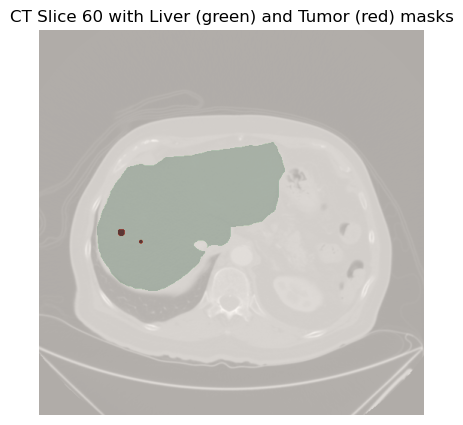

In [ ]:
def show_ct_with_masks(ct_volume, liver_mask, tumor_mask, slice_idx=None):
    
    if slice_idx is None:
        slice_idx = ct_volume.shape[0] // 2  # Middle slice
    
    ct_slice = ct_volume[slice_idx]
    liver_slice = liver_mask[slice_idx]
    tumor_slice = tumor_mask[slice_idx]

    plt.figure(figsize=(5, 5))
    plt.imshow(ct_slice, cmap='gray')
    plt.imshow(liver_slice, cmap='Greens', alpha=0.4)  # Liver mask in green
    plt.imshow(tumor_slice, cmap='Reds', alpha=0.5)   # Tumor mask in red
    plt.title(f'CT Slice {slice_idx} with Liver (green) and Tumor (red) masks')
    plt.axis('off')
    plt.show()

show_ct_with_masks(ct_volume, liver_mask_volume, tumor_mask_volume, slice_idx=60)

### Coronal plane in this function

In [17]:
def calculate_mip_coronal(ct_volume: np.ndarray, tumor_mask_volume: np.ndarray, liver_mask_volume: np.ndarray):

    angles = np.linspace(0, 360, num=16, endpoint=False)
    frames = []

    for angle in angles:
        # Rotate volume around axial axis
        rotated_ct = rotate_on_axial_plane(ct_volume, angle)
        rotated_mask_tumor = rotate_on_axial_plane(tumor_mask_volume, angle)
        rotated_mask_liver = rotate_on_axial_plane(liver_mask_volume, angle)
        
        mip_ct   = MIP_coronal_plane(rotated_ct)
        mip_mask_tumor = MIP_coronal_plane(rotated_mask_tumor) > 0
        mip_mask_liver = MIP_coronal_plane(rotated_mask_liver) > 0
        frames.append((mip_ct, mip_mask_tumor, mip_mask_liver))

    return frames

frames = calculate_mip_coronal(ct_volume=ct_volume, tumor_mask_volume=tumor_mask_volume, liver_mask_volume=liver_mask_volume)

MovieWriter ffmpeg unavailable; using Pillow instead.


Saved results/MIP/rotating_coronal.gif


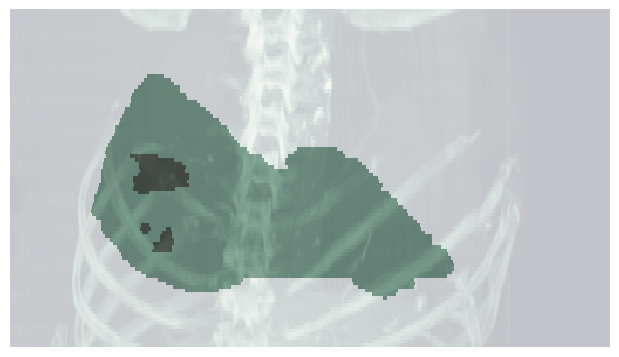

In [18]:
# Prepare your colormap + intensity window
img_min, img_max = np.min(ct_volume), np.max(ct_volume)
cm = plt.colormaps['bone']

# 2) Compute mm spacing for your sagittal MIP:
#    - vertical (rows of proj): slice thickness in mm
#    - horizontal (cols of proj): pixel spacing in mm (x‑direction)
slice_thickness = abs(ct_z_positions[1] - ct_z_positions[0])  # This remains the same for slice thickness
pixel_spacing_x, pixel_spacing_y = ct_files[0].PixelSpacing  # Retrieve pixel spacing from DICOM

# For coronal projection:
pixel_len_mm = [slice_thickness, pixel_spacing_y]  # Swap the pixel spacing direction for coronal plane

# Save each projection as a PNG
for idx, (rotated_ct, rotated_mask_tumor, rotated_mask_liver) in enumerate(frames):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Display CT
    ax.imshow(rotated_ct,
              cmap=cm,
              vmin=img_min, vmax=img_max,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    # Overlay Tumor Mask (Red) with alpha blending
    ax.imshow(rotated_mask_tumor,
              cmap='Reds',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    # Overlay Liver Mask (Green) with alpha blending
    ax.imshow(rotated_mask_liver,
              cmap='Greens',
              alpha=0.4,
              aspect=pixel_len_mm[0] / pixel_len_mm[1],
              interpolation='nearest')

    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'results/MIP/Frame_{idx:02d}.png', bbox_inches='tight')
    plt.close(fig)

# Re-initialize plot for animation
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
plt.tight_layout(pad=0)

animation_frames = []
for proj_ct, proj_mask_tumor, proj_mask_liver in frames:
    # Create animated frame for CT
    im_ct = ax.imshow(proj_ct,
                      cmap=cm,
                      vmin=img_min, vmax=img_max,
                      aspect=pixel_len_mm[0] / pixel_len_mm[1],
                      interpolation='nearest',
                      animated=True)

    # Create animated frame for Tumor Mask (Red)
    im_mask_tumor = ax.imshow(proj_mask_tumor,
                              cmap='Reds',
                              alpha=0.4,
                              aspect=pixel_len_mm[0] / pixel_len_mm[1],
                              interpolation='nearest',
                              animated=True)

    # Create animated frame for Liver Mask (Green)
    im_mask_liver = ax.imshow(proj_mask_liver,
                              cmap='Greens',
                              alpha=0.4,
                              aspect=pixel_len_mm[0] / pixel_len_mm[1],
                              interpolation='nearest',
                              animated=True)

    animation_frames.append([im_ct, im_mask_tumor, im_mask_liver])

# Save out the rotating MIP GIF
anim = animation.ArtistAnimation(
    fig,
    animation_frames,
    interval=100,  # ms between frames (10 fps)
    blit=True
)

anim.save('results/MIP/rotating_MIP_coronal_new.gif')
print("Saved results/MIP/rotating_coronal.gif")


In [19]:
def get_bounding_box_and_centroid(mask: np.ndarray):
    # Get coordinates of non-zero (tumor) voxels
    coords = np.argwhere(mask > 0)

    if coords.size == 0:
        raise ValueError("No non-zero voxels found in the mask.")

    # Bounding box: min and max in Z, Y, X
    min_z, min_y, min_x = coords.min(axis=0)
    max_z, max_y, max_x = coords.max(axis=0)

    bbox = {
        'min': (min_z, min_y, min_x),
        'max': (max_z, max_y, max_x),
        'shape': (max_z - min_z + 1, max_y - min_y + 1, max_x - min_x + 1)
    }

    # Centroid (floating-point)
    centroid = coords.mean(axis=0)  # returns (z, y, x)
    print(f"\n Bounding Box:")
    print(f"  Min: {bbox['min']}")
    print(f"  Max: {bbox['max']}")
    print(f"  Shape: {bbox['shape']}")

    print("\n Centroid (Z, Y, X):")
    print(centroid)
    return bbox, centroid

In [31]:
bbox_tumor, centroid_tumor = get_bounding_box_and_centroid(tumor_mask_volume)
bbox_liver, centroid_liver = get_bounding_box_and_centroid(liver_mask_volume)


 Bounding Box:
  Min: (40, 265, 105)
  Max: (66, 340, 156)
  Shape: (27, 76, 52)

 Centroid (Z, Y, X):
[ 46.91122747 298.53007793 134.22601072]

 Bounding Box:
  Min: (18, 146, 74)
  Max: (79, 359, 360)
  Shape: (62, 214, 287)

 Centroid (Z, Y, X):
[ 54.96733176 243.67789759 181.28325049]


### Check and edit

In [32]:
from collections import deque
def region_growing_bounding_box(ct_volume: np.ndarray, seed: tuple, bbox: dict, threshold: float = 5.0) -> np.ndarray:
    """
    Region growing limited to a bounding box.
    
    Parameters:
    - ct_volume: 3D CT image (Z, Y, X)
    - seed: (z, y, x) coordinates (absolute in full volume)
    - bbox: dict with 'min' and 'max' keys, each a tuple of (z,y,x) bounds
    - threshold: allowable intensity difference from seed
    
    Returns:
    - mask: binary mask (same shape as ct_volume) with segmented region inside bbox
    """
    z_dim, y_dim, x_dim = ct_volume.shape
    seed_z, seed_y, seed_x = map(int, seed)
    seed_intensity = ct_volume[seed_z, seed_y, seed_x]
    
    # Bounding box limits
    z_min, y_min, x_min = bbox['min']
    z_max, y_max, x_max = bbox['max']
    
    visited = np.zeros_like(ct_volume, dtype=bool)
    mask = np.zeros_like(ct_volume, dtype=np.uint8)
    
    queue = deque()
    queue.append((seed_z, seed_y, seed_x))
    visited[seed_z, seed_y, seed_x] = True

    while queue:
        z, y, x = queue.popleft()
        
        # Check if voxel is inside bounding box
        if not (z_min <= z <= z_max and y_min <= y <= y_max and x_min <= x <= x_max):
            continue
        
        current_intensity = ct_volume[z, y, x]
        
        if abs(current_intensity - seed_intensity) <= threshold:
            mask[z, y, x] = 1
            
            # 6-connectivity neighbors
            for dz, dy, dx in [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]:
                nz, ny, nx = z+dz, y+dy, x+dx
                if 0 <= nz < z_dim and 0 <= ny < y_dim and 0 <= nx < x_dim:
                    if not visited[nz, ny, nx]:
                        visited[nz, ny, nx] = True
                        queue.append((nz, ny, nx))
    
    return mask


In [33]:
predicted_mask = region_growing_bounding_box(ct_volume, seed=centroid_tumor, bbox=bbox_tumor, threshold=20.0)

In [15]:
from collections import deque

def region_growing(ct_volume: np.ndarray, seed: tuple, threshold: float = 5.0) -> np.ndarray:
    """
    Simple region growing from a seed point using intensity similarity.
    
    Parameters:
    - ct_volume: 3D CT image
    - seed: (z, y, x) coordinates
    - threshold: allowable intensity difference from seed
    
    Returns:
    - mask: binary segmentation result (same shape as ct_volume)
    """
    z_dim, y_dim, x_dim = ct_volume.shape
    seed_z, seed_y, seed_x = map(int, seed)
    seed_intensity = ct_volume[seed_z, seed_y, seed_x]
    
    visited = np.zeros_like(ct_volume, dtype=bool)
    mask = np.zeros_like(ct_volume, dtype=np.uint8)
    
    queue = deque()
    queue.append((seed_z, seed_y, seed_x))
    visited[seed_z, seed_y, seed_x] = True

    while queue:
        z, y, x = queue.popleft()
        current_intensity = ct_volume[z, y, x]
        
        if abs(current_intensity - seed_intensity) <= threshold:
            mask[z, y, x] = 1
            
            # 6-connectivity: check neighbors
            for dz, dy, dx in [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]:
                nz, ny, nx = z+dz, y+dy, x+dx
                if 0 <= nz < z_dim and 0 <= ny < y_dim and 0 <= nx < x_dim:
                    if not visited[nz, ny, nx]:
                        visited[nz, ny, nx] = True
                        queue.append((nz, ny, nx))
    
    return mask

In [ ]:
# Assuming you have CT volume and centroid from previous step
predicted_mask = region_growing(ct_volume, seed=centroid_tumor, threshold=5.0)

# View nonzero voxel count
print("🧠 Predicted tumor voxels:", np.count_nonzero(predicted_mask))

🧠 Predicted tumor voxels: 3924790


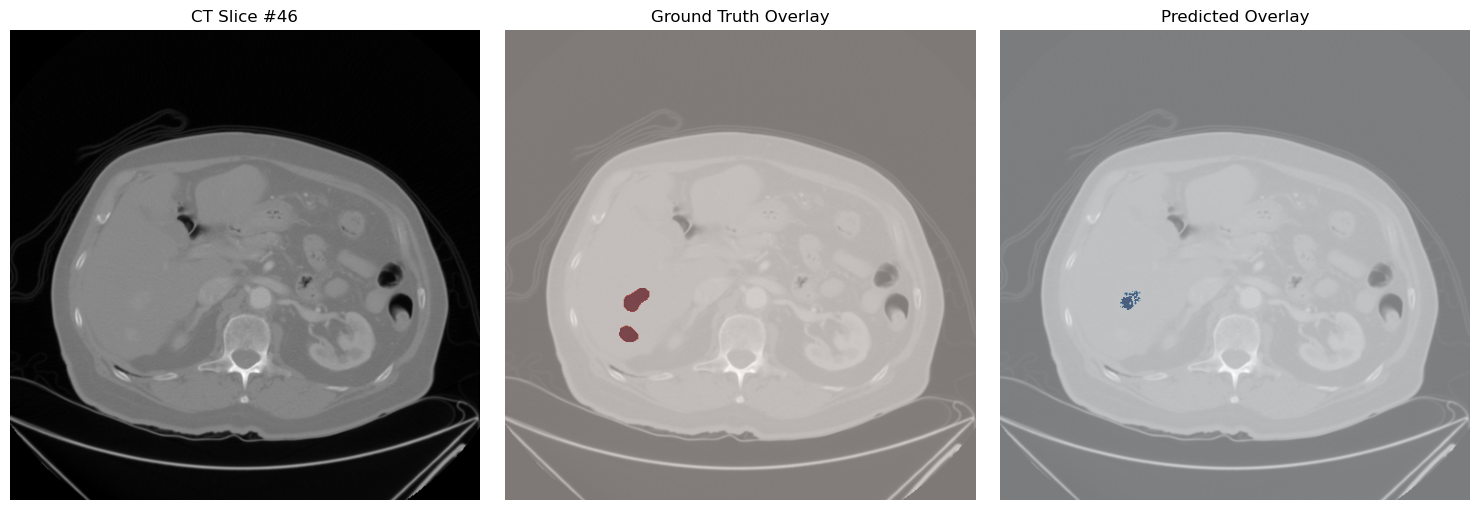

In [34]:
import matplotlib.pyplot as plt

def show_overlay(ct_volume, true_mask, pred_mask, slice_index=None):
    if slice_index is None:
        # Pick middle slice of tumor
        slice_index = np.mean(np.argwhere(true_mask > 0)[:, 0]).astype(int)

    ct_slice = ct_volume[slice_index]
    gt_slice = true_mask[slice_index]
    pred_slice = pred_mask[slice_index]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(ct_slice, cmap='gray')
    ax[0].set_title(f"CT Slice #{slice_index}")

    ax[1].imshow(ct_slice, cmap='gray')
    ax[1].imshow(gt_slice, alpha=0.5, cmap='Reds')
    ax[1].set_title("Ground Truth Overlay")

    ax[2].imshow(ct_slice, cmap='gray')
    ax[2].imshow(pred_slice, alpha=0.5, cmap='Blues')
    ax[2].set_title("Predicted Overlay")

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

show_overlay(ct_volume, tumor_mask_volume, predicted_mask)

### Try with the bounding box

In [29]:
print("Tumor voxels in true_mask on slice 5:", np.sum(tumor_mask[5]))

Tumor voxels in true_mask on slice 5: 821
